In [335]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df_train = pd.read_csv("houses_train.csv")
df_train = df_train.drop(columns = ["Id"])

In [336]:
df_test = pd.read_csv("houses_1_test.csv")
df_test = df_test.drop(columns = ["Id"])

## 1 - Find missing data

First we want to see what kind of variables we have in our hand and how many missing values we have on each

In [337]:
missing_data = df_train.isnull() # Returns a DataFrame with True/False depending on the existence of a missing value
true_counts = [(column, np.count_nonzero(missing_data[column] == True)) for column in missing_data.columns]
false_counts = [(column, np.count_nonzero(missing_data[column] == False)) for column in missing_data.columns]

In [338]:
df_train_numeric = df_train.select_dtypes(exclude="object")
df_test_numeric = df_test.select_dtypes(exclude="object")

In [339]:
missing_data = df_train_numeric.isnull() # Returns a DataFrame with True/False depending on the existence of a missing value
true_counts = [(column, np.count_nonzero(missing_data[column] == True)) for column in missing_data.columns]
false_counts = [(column, np.count_nonzero(missing_data[column] == False)) for column in missing_data.columns]

In [340]:
missing_data = df_test_numeric.isnull() # Returns a DataFrame with True/False depending on the existence of a missing value
true_counts = [(column, np.count_nonzero(missing_data[column] == True)) for column in missing_data.columns]
false_counts = [(column, np.count_nonzero(missing_data[column] == False)) for column in missing_data.columns]

In [341]:
df_test_numeric.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

## 2 - Impute / drop columns with missing data

Seems like there are only 3-4 variables with missing values:

* `LotFrontage`
    * Train: 259/860
    * Test: 73/300
* `GarageYrBlt` -> 81/860
    * Train: 81/860
    * Test: 10/300
* `MasVnrArea` -> 8/860
    * Train: 8/860
    * Test: 3/300
* `PoolQC`
    * Train: 0
    * Test: 300

A simple rule is to exclude those with more than 10% of missing values and impute the others.

#### LotFrontage

In [342]:
df_train_numeric = df_train_numeric.drop(columns=["LotFrontage"])
df_test_numeric = df_test_numeric.drop(columns=["LotFrontage"])

#### PoolQC

In [343]:
df_test_numeric = df_test_numeric.drop(columns=["PoolQC"])

#### MasVnrArea

In [344]:
from sklearn.impute import SimpleImputer

mean_imputer = SimpleImputer(missing_values=np.nan, strategy='median')

# Train
imputed = mean_imputer.fit_transform(df_train_numeric[["MasVnrArea"]]) # It expects DataFrame (not a Series object)
df_train_numeric["MasVnrArea"] = imputed

# Test
imputed = mean_imputer.fit_transform(df_test_numeric[["MasVnrArea"]]) # It expects DataFrame (not a Series object)
df_test_numeric["MasVnrArea"] = imputed

#### GarageYrBuilt

In [345]:
from sklearn.impute import SimpleImputer

mean_imputer = SimpleImputer(missing_values=np.nan, strategy='median')

imputed = mean_imputer.fit_transform(df_train_numeric[["GarageYrBlt"]]) # It expects DataFrame (not a Series object)
df_train_numeric["GarageYrBlt"] = imputed

# Test
imputed = mean_imputer.fit_transform(df_test_numeric[["GarageYrBlt"]]) # It expects DataFrame (not a Series object)
df_test_numeric["GarageYrBlt"] = imputed

## 3 - Correlation

Some questions we want to answer:

* Are there any variables that at first glance may be problematic?
* Can we select a variable with high correlation with the SalePrice that can predict its value with a very simple model?

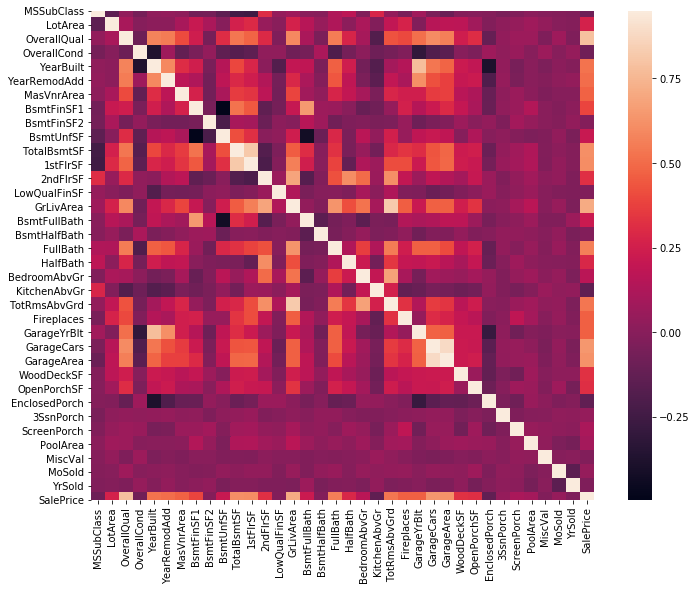

In [346]:
corr = df_train_numeric.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr, vmax=.95, square=True)

There may be some problems of multicollinarity between:
* TotalBsmtSF & 1FlrSF
* GarageCars & GarageArea

we are going to 1 of remove each (the other one will give the same information)

In [347]:
df_train_numeric = df_train_numeric.drop(columns=["1stFlrSF", "GarageArea"])
df_test_numeric = df_test_numeric.drop(columns =["1stFlrSF", "GarageArea"])

# 4 - Regression Analysis

In [348]:
X_train = df_train_numeric.drop(columns=["SalePrice"])
Y_train = df_train_numeric["SalePrice"]

X_test = df_test_numeric.drop(columns=["SalePrice"])
Y_test = df_test_numeric["SalePrice"]

In [349]:
len(X_train.columns)

33

In [350]:
len(X_test.columns)

33

## Simple linear regression with 1 variable

In [351]:
X_train_overall = X_train[["OverallQual"]]
X_test_overall = X_test[["OverallQual"]]

In [352]:
from sklearn import linear_model
reg = linear_model.LinearRegression(n_jobs=4)

In [353]:
fitted_reg = reg.fit(X_train_overall, Y_train)
print(fitted_reg.coef_)

print("Train score: " + str(fitted_reg.score(X_train_overall, Y_train)))
print("Test score: " + str(fitted_reg.score(X_test_overall, Y_test)))

[45435.8025931]
Train score: 0.625651892462118
Test score: 0.6510079350916393


### Manually choose 2 variables

Note: Doing this to find the best subset of features (comprison with test) would generate overfitting

In [354]:
X_train_overall_2 = X_train[["OverallQual", "OverallCond"]]
X_test_overall_2 = X_test[["OverallQual", "OverallCond"]]

In [357]:
from sklearn import linear_model
reg = linear_model.LinearRegression(n_jobs=4)

In [358]:
fitted_reg = reg.fit(X_train_overall_2, Y_train)
print(fitted_reg.coef_)
print("Train score: " + str(fitted_reg.score(X_train_overall_2, Y_train)))
print("Test score: " + str(fitted_reg.score(X_test_overall_2, Y_test)))

[45408.43267524  -370.00654346]
Train score: 0.6256785279481476
Test score: 0.6507977681288253


## Linear regression with Cross-validated Feture selection

In [359]:
from sklearn.feature_selection import RFECV

estimator = linear_model.LinearRegression()
selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(X_train, Y_train)

In [360]:
selector.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [366]:
X_train_selected = X_train[X_train.columns[selector.support_]]
X_test_selected = X_test[X_test.columns[selector.support_]]

In [367]:
print(len(X_test_selected.columns))
print(len(X_train_selected.columns))

33
33


In [369]:
from sklearn import linear_model

reg_fitted_with_selection = linear_model.LinearRegression(n_jobs=4)
reg_fitted_with_selection = reg.fit(X_train_selected, Y_train)
print("Train score: " + str(reg_fitted_with_selection.score(X_train_selected, Y_train)))
print("Test score: " + str(reg_fitted_with_selection.score(X_test_selected, Y_test)))

Train score: 0.8129720199152773
Test score: 0.8615783620536767


## Lasso Regression

Voy manualmente a probar varias alphas para el lasso regression

In [383]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score

lasso_1_0 = Lasso(alpha=0.1)
scores = cross_val_score(lasso_1_0, X_train, Y_train, cv=5)
scores.mean()

0.7924083911575523

In [377]:
lasso_2_0 = Lasso(alpha=2.0)
scores = cross_val_score(lasso_2_0, X_train, Y_train, cv=5)
scores.mean()

0.7924119212446141

In [385]:
lasso_20 = Lasso(alpha=20.0)
scores = cross_val_score(lasso_150, X_train, Y_train, cv=5)
scores.mean()

0.7924388255461211

## Validation with test data

In [386]:
lasso_20 = lasso_20.fit(X_train_selected, Y_train)
lasso_20.score(X_test_selected, Y_test)

0.8615859779194233

## Ridge regression

In [322]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

ridge_0_1 = Ridge(alpha=0.1)
scores = cross_val_score(ridge_0_1, X_train_selected, Y_train, cv=5)
scores.mean()

0.789520213319021

In [323]:
ridge_1_0 = Ridge(alpha=1.0)
scores = cross_val_score(ridge_1_0, X_train_selected, Y_train, cv=5)
scores.mean()

0.789590512694744

In [324]:
ridge_100 = Ridge(alpha=100.0)
scores = cross_val_score(ridge_100, X_train_selected, Y_train, cv=5)
scores.mean()

0.7910376692190602

## Validation with test data

In [325]:
ridge_100 = ridge_100.fit(X_train_selected, Y_train)
ridge_100.score(X_test_selected, Y_test)

0.8606455608366155

## Random forest regressor

In [456]:
from sklearn.ensemble import RandomForestRegressor

regr_2_10 = RandomForestRegressor(max_depth=10, random_state=0, n_estimators = 100)
regr_10_10 = RandomForestRegressor(max_depth=2, random_state=0, n_estimators = 10)
regr_10_100 = RandomForestRegressor(max_depth=10, random_state=0, n_estimators = 100)
regr_15_150 = RandomForestRegressor(max_depth=15, random_state=0, n_estimators = 150)
regr_20_200 = RandomForestRegressor(max_depth=20, random_state=0, n_estimators = 200)

In [457]:
scores = cross_val_score(regr_2_10, X_train, Y_train, cv=5)
print(scores.mean())

scores = cross_val_score(regr_10_10, X_train, Y_train, cv=5)
print(scores.mean())

scores = cross_val_score(regr_10_100, X_train, Y_train, cv=5)
print(scores.mean())

scores = cross_val_score(regr_15_150, X_train, Y_train, cv=5)
print(scores.mean())

scores = cross_val_score(regr_20_200, X_train, Y_train, cv=5)
print(scores.mean())

0.8487112447538363
0.6681306201571602
0.8487112447538363
0.8508511876146907
0.8521969343871738


## Validation with test data

In [458]:
regr_20_200 = regr_20_200.fit(X_train_selected, Y_train)

In [459]:
regr_20_200.score(X_test, Y_test)

0.9815559221203134

----
----
----

# 5 - Regression analysis after standarization

Lets apply StandardScaler to see if we can get a better performance by standarizaing them. I dont like that they have very different values, that may prove to mess with the results

In [425]:
X_train_standard = df_train_numeric.drop(columns=["SalePrice"])
Y_train_standard = df_train_numeric[["SalePrice"]]

X_test_standard = df_test_numeric.drop(columns=["SalePrice"])
Y_test_standard = df_test_numeric[["SalePrice"]]

In [426]:
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler().fit(X_train_standard)
scaler_Y = StandardScaler().fit(Y_train_standard)

In [427]:
X_train_standard = pd.DataFrame(scaler_X.transform(X_train_standard))
X_test_standard = pd.DataFrame(scaler_X.transform(X_test_standard))

Y_train_standard = pd.DataFrame(scaler_Y.transform(Y_train_standard))
Y_test_standard = pd.DataFrame(scaler_Y.transform(Y_test_standard))

## 5.1 - Feature selection with CV

In [428]:
from sklearn.feature_selection import RFECV

estimator = linear_model.LinearRegression()
selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(X_train_standard, Y_train)
selector.support_

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
       False,  True, False, False,  True,  True, False,  True, False,
        True,  True,  True,  True,  True,  True,  True, False, False,
       False,  True,  True, False, False, False])

In [429]:
X_train_standard_selected = X_train_standard[X_train_standard.columns[selector.support_]]
X_test_standard_selected = X_test_standard[X_test_standard.columns[selector.support_]]

### 5.1.1 - Linear regression

In [430]:
from sklearn import linear_model

reg_fitted_with_selection = linear_model.LinearRegression(n_jobs=4)
reg_fitted_with_selection = reg.fit(X_train_standard_selected, Y_train)
print("Train score: " + str(reg_fitted_with_selection.score(X_train_standard_selected, Y_train)))
print("Test score: " + str(reg_fitted_with_selection.score(X_test_standard_selected, Y_test)))

Train score: 0.8123790695483548
Test score: 0.8607641418033257


### 5.2 - Lasso regression

In [445]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score

lasso_0_1 = Lasso(alpha=0.1)
scores = cross_val_score(lasso_0_1_standard, X_train_standard_selected, Y_train, cv=5)
print(scores.mean())

0.7957965123293891


### Validation with test data

In [446]:
lasso_0_1_fitted = lasso_0_1.fit(X_train_standard_selected, Y_train)
print("Train score: " + str(lasso_0_1_fitted.score(X_train_standard_selected, Y_train)))
print("Test score: " + str(lasso_0_1_fitted.score(X_test_standard_selected, Y_test)))

Train score: 0.8123790695245885
Test score: 0.8607637819021605


----
----
----
----

# Validation of our chosen model with test_1 and test_2

In [462]:
test_1 = X_test

In [464]:
test_2 = pd.read_csv("houses_2_test.csv")

In [466]:
test_2_numeric = test_2.select_dtypes(exclude="object")

In [467]:
missing_data = test_2_numeric.isnull() # Returns a DataFrame with True/False depending on the existence of a missing value
true_counts = [(column, np.count_nonzero(missing_data[column] == True)) for column in missing_data.columns]
false_counts = [(column, np.count_nonzero(missing_data[column] == False)) for column in missing_data.columns]
true_counts

[('Id', 0),
 ('MSSubClass', 0),
 ('LotFrontage', 52),
 ('LotArea', 0),
 ('OverallQual', 0),
 ('OverallCond', 0),
 ('YearBuilt', 0),
 ('YearRemodAdd', 0),
 ('MasVnrArea', 1),
 ('BsmtFinSF1', 0),
 ('BsmtFinSF2', 0),
 ('BsmtUnfSF', 0),
 ('TotalBsmtSF', 0),
 ('1stFlrSF', 0),
 ('2ndFlrSF', 0),
 ('LowQualFinSF', 0),
 ('GrLivArea', 0),
 ('BsmtFullBath', 0),
 ('BsmtHalfBath', 0),
 ('FullBath', 0),
 ('HalfBath', 0),
 ('BedroomAbvGr', 0),
 ('KitchenAbvGr', 0),
 ('TotRmsAbvGrd', 0),
 ('Fireplaces', 0),
 ('GarageYrBlt', 18),
 ('GarageCars', 0),
 ('GarageArea', 0),
 ('WoodDeckSF', 0),
 ('OpenPorchSF', 0),
 ('EnclosedPorch', 0),
 ('3SsnPorch', 0),
 ('ScreenPorch', 0),
 ('PoolArea', 0),
 ('MiscVal', 0),
 ('MoSold', 0),
 ('YrSold', 0),
 ('SalePrice', 0)]